# Analyze kinetic Infinite M1000PRO experiments

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import pandas as pd
from lxml import etree
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib
from glob import glob

import assaytools

from assaytools import platereader

In [2]:
concentrations = np.array([  0.00000000e+00,   8.00000000e-09,   1.75e-08,
         3.83e-08,   8.37e-08,   1.83e-07,
         4e-07,   8.75e-07,   1.91e-06,
         4.18e-06,   9.15e-06,   2e-05])

In [3]:
# Get list of data directories, which may contain multiple experiments each
directories = os.listdir('data')
print(directories)

['Greiner 96 Flat Bottom Transparent Polystyrene cat no 655101,655161,655192 [GRE96ft]']


In [4]:
# Define helper function for reading Tecan M1000PRO kinetic experiment

def read_icontrol_kinetic_xml(filename):
    """
    Read a Tecan iControl XML-formatted file kinetic timeseries experiment and return all section data.
    
    Parameters
    ----------
    filename : str
        The name of the XML file to be read.

    Returns
    -------
    data : dict
       data[cycle]['Measurements'][well_label][label_id] is the well reading for well 'well_label' for 0-indexed cycle 'cycle' for LabelId 'label_id' (e.g. data[1]["Wells']['A4'][1] = 954)
       data[cycle]['Time_Start'] is the time (in minutes) of the measurement 'cycle'
       data[cycle]['Temperature'] is the temperature (in Celsius) of the measurement       
       
    Examples
    --------
    
    """
    import numpy as np
    import re
    import string
    from lxml import etree
    
    root_node = etree.parse(filename)
    
    # Determine number of labels
    # TODO: This is an ugly hack
    matches = re.match('(\d+) Labels', root_node.xpath("/*/Section")[0].get('Name'))
    nlabels = int(matches[1])

    # Populate cycles
    data = dict()
    for cycle_root in root_node.xpath("/*/Section/Data"):
        # Get 1-indexed Cycle id
        cycle = int(cycle_root.get('Cycle')) - 1
        # Initialize cycle
        data[cycle] = dict()
        # Get temperature
        temperature = float(cycle_root.get('Temperature'))
        # Get cycle start time (in minutes since experiment start)
        matches = re.match('^PT((?P<hours>\d+)H)?((?P<minutes>\d+)M)?((?P<seconds>[\d\.]+)S)?$', cycle_root.get('Time_Start'))
        start_time = 0.0
        if matches.group('hours'):
            start_time += float(matches.group('hours')) * 60.
        if matches.group('minutes'):
            start_time += float(matches.group('minutes'))
        if matches.group('seconds'):
            start_time += float(matches.group('seconds')) / 60.    
        data[cycle]['Temperature'] = temperature
        data[cycle]['Time_Start'] = start_time
        # Get well data
        data[cycle]['Measurements'] = dict()   
        for well_root in cycle_root.xpath("Well"):
            well = well_root.get('Pos')
            data[cycle]['Measurements'][well] = dict()
            for measurement_node in well_root.xpath('Single'):
                label_id = measurement_node.get('LabelId')
                measurement = float(measurement_node.text)
                data[cycle]['Measurements'][well][label_id] = measurement
    
    return data

In [5]:
# plot fluo trace across concentrations with colormap of each timepoint, logx with or without ylim
def fluo_trace_logx(ax1, prot, lig, y_prot, y_buff):
    
    ncycles, ncol = y_prot.shape
    
    for n in range(ncycles):
        x_values = concentrations
        color = cm.rainbow(np.linspace(0,1,20))
        for read, c in zip(y_prot, color):
            plt.semilogx(x_values, np.flip(read), c=c, linestyle='solid')
        for read, c in zip(y_buff, color):
            plt.semilogx(x_values, np.flip(read), c=c, linestyle='dotted')
        
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=16)
        plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=16)
        
        plt.title('%s:%s' % (prot, lig), fontsize =25)
        anchored_text = AnchoredText('Protein = solid \nBuffer = dashed',  loc='upper left', prop=dict(size=16))
        ax1.add_artist(anchored_text)
        
def plot_time_dependent(data):
    # Determine number of kinetic measurement cycles
    ncycles = len([cycle for cycle in data])    
    ncol = 12
                
    # Format data for plotting
    plotting_data = dict()
    for system in systems:
        complex_row, buffer_row = systems[system]
        plotting_data[system] = dict()
        plotting_data[system]['complex'] = np.zeros([ncycles, ncol], np.float64)
        plotting_data[system]['buffer'] = np.zeros([ncycles, ncol], np.float64)

        complex_wells = [ f'{complex_row}{index+1}' for index in range(12) ]
        buffer_wells = [ f'{buffer_row}{index+1}' for index in range(12) ]

        for cycle in range(ncycles):
            plotting_data[system]['complex'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in complex_wells])
            plotting_data[system]['buffer'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in buffer_wells])
    
    fig = plt.figure(figsize=(20,16), dpi=300)
    plt.subplots_adjust(hspace=0.3)

    ax1 = fig.add_subplot(2,2,1)
    Abl_bos = fluo_trace_logx(ax1, prot='Abl WT', lig='Bosutinib', y_prot=plotting_data['Abl:BOS']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    ax1 = fig.add_subplot(2,2,2)
    Abl_erl = fluo_trace_logx(ax1, prot='Abl WT', lig='Erlotinib', y_prot=plotting_data['Abl:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    ax1 = fig.add_subplot(2,2,3)
    Src_bos = fluo_trace_logx(ax1, prot='Src WT', lig='Bosutinib', y_prot=plotting_data['Src:BOS']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    axis = plt.gca()
    plt.ylabel('Fluorescence Intensity (rfu)', fontsize=24)
    axis.yaxis.set_label_coords(-0.15,1.25)
    plt.xlabel('Concentration (M)', fontsize=24)
    axis.xaxis.set_label_coords(1,-0.2)

    ax1 = fig.add_subplot(2,2,4)
    Src_erl = fluo_trace_logx(ax1, prot='Src WT', lig='Erlotinib', y_prot=plotting_data['Src:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])


    cax = fig.add_axes([.92, 0.127, 0.03, 0.75])

    time = [i for i in range(ncycles)] 
    time_mins = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
    time_wait = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
    norm = matplotlib.colors.BoundaryNorm(range(ncycles), cm.rainbow.N)
    cmap = plt.get_cmap('rainbow')
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=range(ncycles), boundaries=range(ncycles))
    cb.set_label('Time in Infinite (minutes)', fontsize=23)
    cb.ax.tick_params(labelsize=16)
    cb.ax.set_yticklabels(time_wait)

    return fig
    

In [6]:
# plot fluo values across time with colormap of each concentration 

def fluo_time_plot(time_wait, ax1, prot, lig, y_prot, y_buff):

    ncycles, ncol = y_prot.shape
    
    for i in range(ncol):
        x_values_time = time_wait
        
        color = cm.rainbow(np.linspace(0,1,12))
        for read, c in zip(y_prot.T, color):
            plt.plot(x_values_time, read, c=c, linestyle='solid', linewidth=2)
        for read, c in zip(y_buff.T, color):
            plt.plot(x_values_time, read, c=c, linestyle='dotted', linewidth=2)
        
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=16)
        plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=16)
        
        plt.title('%s:%s' % (prot, lig), fontsize =25)
        anchored_text = AnchoredText('Protein = solid, Buffer = dashed',  loc='upper right', prop=dict(size=16))
        ax1.add_artist(anchored_text)
        
def plot_concentration_dependent(data):
    # Determine number of kinetic measurement cycles
    ncycles = len([cycle for cycle in data])    
    ncol = 12
                
    # Format data for plotting
    plotting_data = dict()
    for system in systems:
        complex_row, buffer_row = systems[system]
        plotting_data[system] = dict()
        plotting_data[system]['complex'] = np.zeros([ncycles, ncol], np.float64)
        plotting_data[system]['buffer'] = np.zeros([ncycles, ncol], np.float64)

        complex_wells = [ f'{complex_row}{index+1}' for index in range(12) ]
        buffer_wells = [ f'{buffer_row}{index+1}' for index in range(12) ]

        for cycle in range(ncycles):
            plotting_data[system]['complex'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in complex_wells])
            plotting_data[system]['buffer'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in buffer_wells])

    # create list of timepoints (20 reads that take 5 mins per read, 17 minute wait time after the first 10 reads)
    time = [i for i in range(ncycles)] 
    time_mins = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
    time_wait = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]            

    # TODO: Generalize this to use 'systems'
    nrows=2
    ncols=2

    fig = plt.figure(figsize=(20,16), dpi=300)

    plt.subplots_adjust(hspace=0.3)

    ax1 = fig.add_subplot(2,2,1)
    Abl_bos = fluo_time_plot(time_wait, ax1, prot='Abl WT', lig='Bosutinib', y_prot=plotting_data['Abl:BOS']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    ax1 = fig.add_subplot(2,2,2)
    Abl_erl = fluo_time_plot(time_wait, ax1, prot='Abl WT', lig='Erlotinib', y_prot=plotting_data['Abl:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    ax1 = fig.add_subplot(2,2,3)
    Src_bos = fluo_time_plot(time_wait, ax1, prot='Src WT', lig='Bosutinib', y_prot=plotting_data['Src:BOS']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    axis = plt.gca()
    plt.ylabel('Fluorescence Intensity (rfu)', fontsize=24)
    axis.yaxis.set_label_coords(-0.15,1.25)
    plt.xlabel('Time (minutes)', fontsize=24)
    axis.xaxis.set_label_coords(1,-0.2)

    ax1 = fig.add_subplot(2,2,4)
    Src_erl = fluo_time_plot(time_wait, ax1, prot='Src WT', lig='Erlotinib', y_prot=plotting_data['Src:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

    cax = fig.add_axes([.92, 0.127, 0.03, 0.75])

    micro_concentrations = np.multiply(concentrations, 1e6)
    norm = matplotlib.colors.BoundaryNorm(micro_concentrations, cm.rainbow.N)
    conc_labels = ['{0:.3f}'.format(x) for x in micro_concentrations]
    cmap = plt.get_cmap('rainbow')
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=micro_concentrations, boundaries=micro_concentrations)
    cb.set_label('Ligand Concentration ($\mu$M)', fontsize=35, fontweight='bold')
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_yticklabels(conc_labels)

    return fig

In [7]:
# Define helper function for generating plots
def analyze_experiment(plate_type, experiment):
    print(plate_type, experiment)
    filename = os.path.join('data', plate_type, experiment + '.xml')
    if not os.path.exists(filename):
        print(f'{filename} could not be found')
        return

    # Read data
    data = read_icontrol_kinetic_xml(filename)
    
            
    # Generate time-dependent trace plots
    # TODO: Generalize this to use 'systems'
    fig = plot_time_dependent(data)
    fig.savefig(f'{plate_type} - {experiment} - fluo_trace_overtime_logx.pdf', bbox_inches='tight', dpi=300)            
    
    # Generate concentration-dependent trace plots
    fig = plot_concentration_dependent(data)
    fig.savefig(f'{plate_type} - {experiment} - well_values_overtime.pdf', bbox_inches='tight', dpi=300)
            

In [8]:
# Configure experiments

label_id = '8' # Ex 280 bw 20 / Em 480 bw 10 / gain 100 / top read

systems = { 
    'Abl:BOS' : ('A', 'B'), 
    'Abl:ERL' : ('C', 'D'),
    'Src:BOS' : ('E', 'F'),
    'Src:ERL' : ('G', 'H'),
}
nsystems = len(systems)


Greiner 96 Flat Bottom Transparent Polystyrene cat no 655101,655161,655192 [GRE96ft] 2021-04-08 13-08-30_plate_1


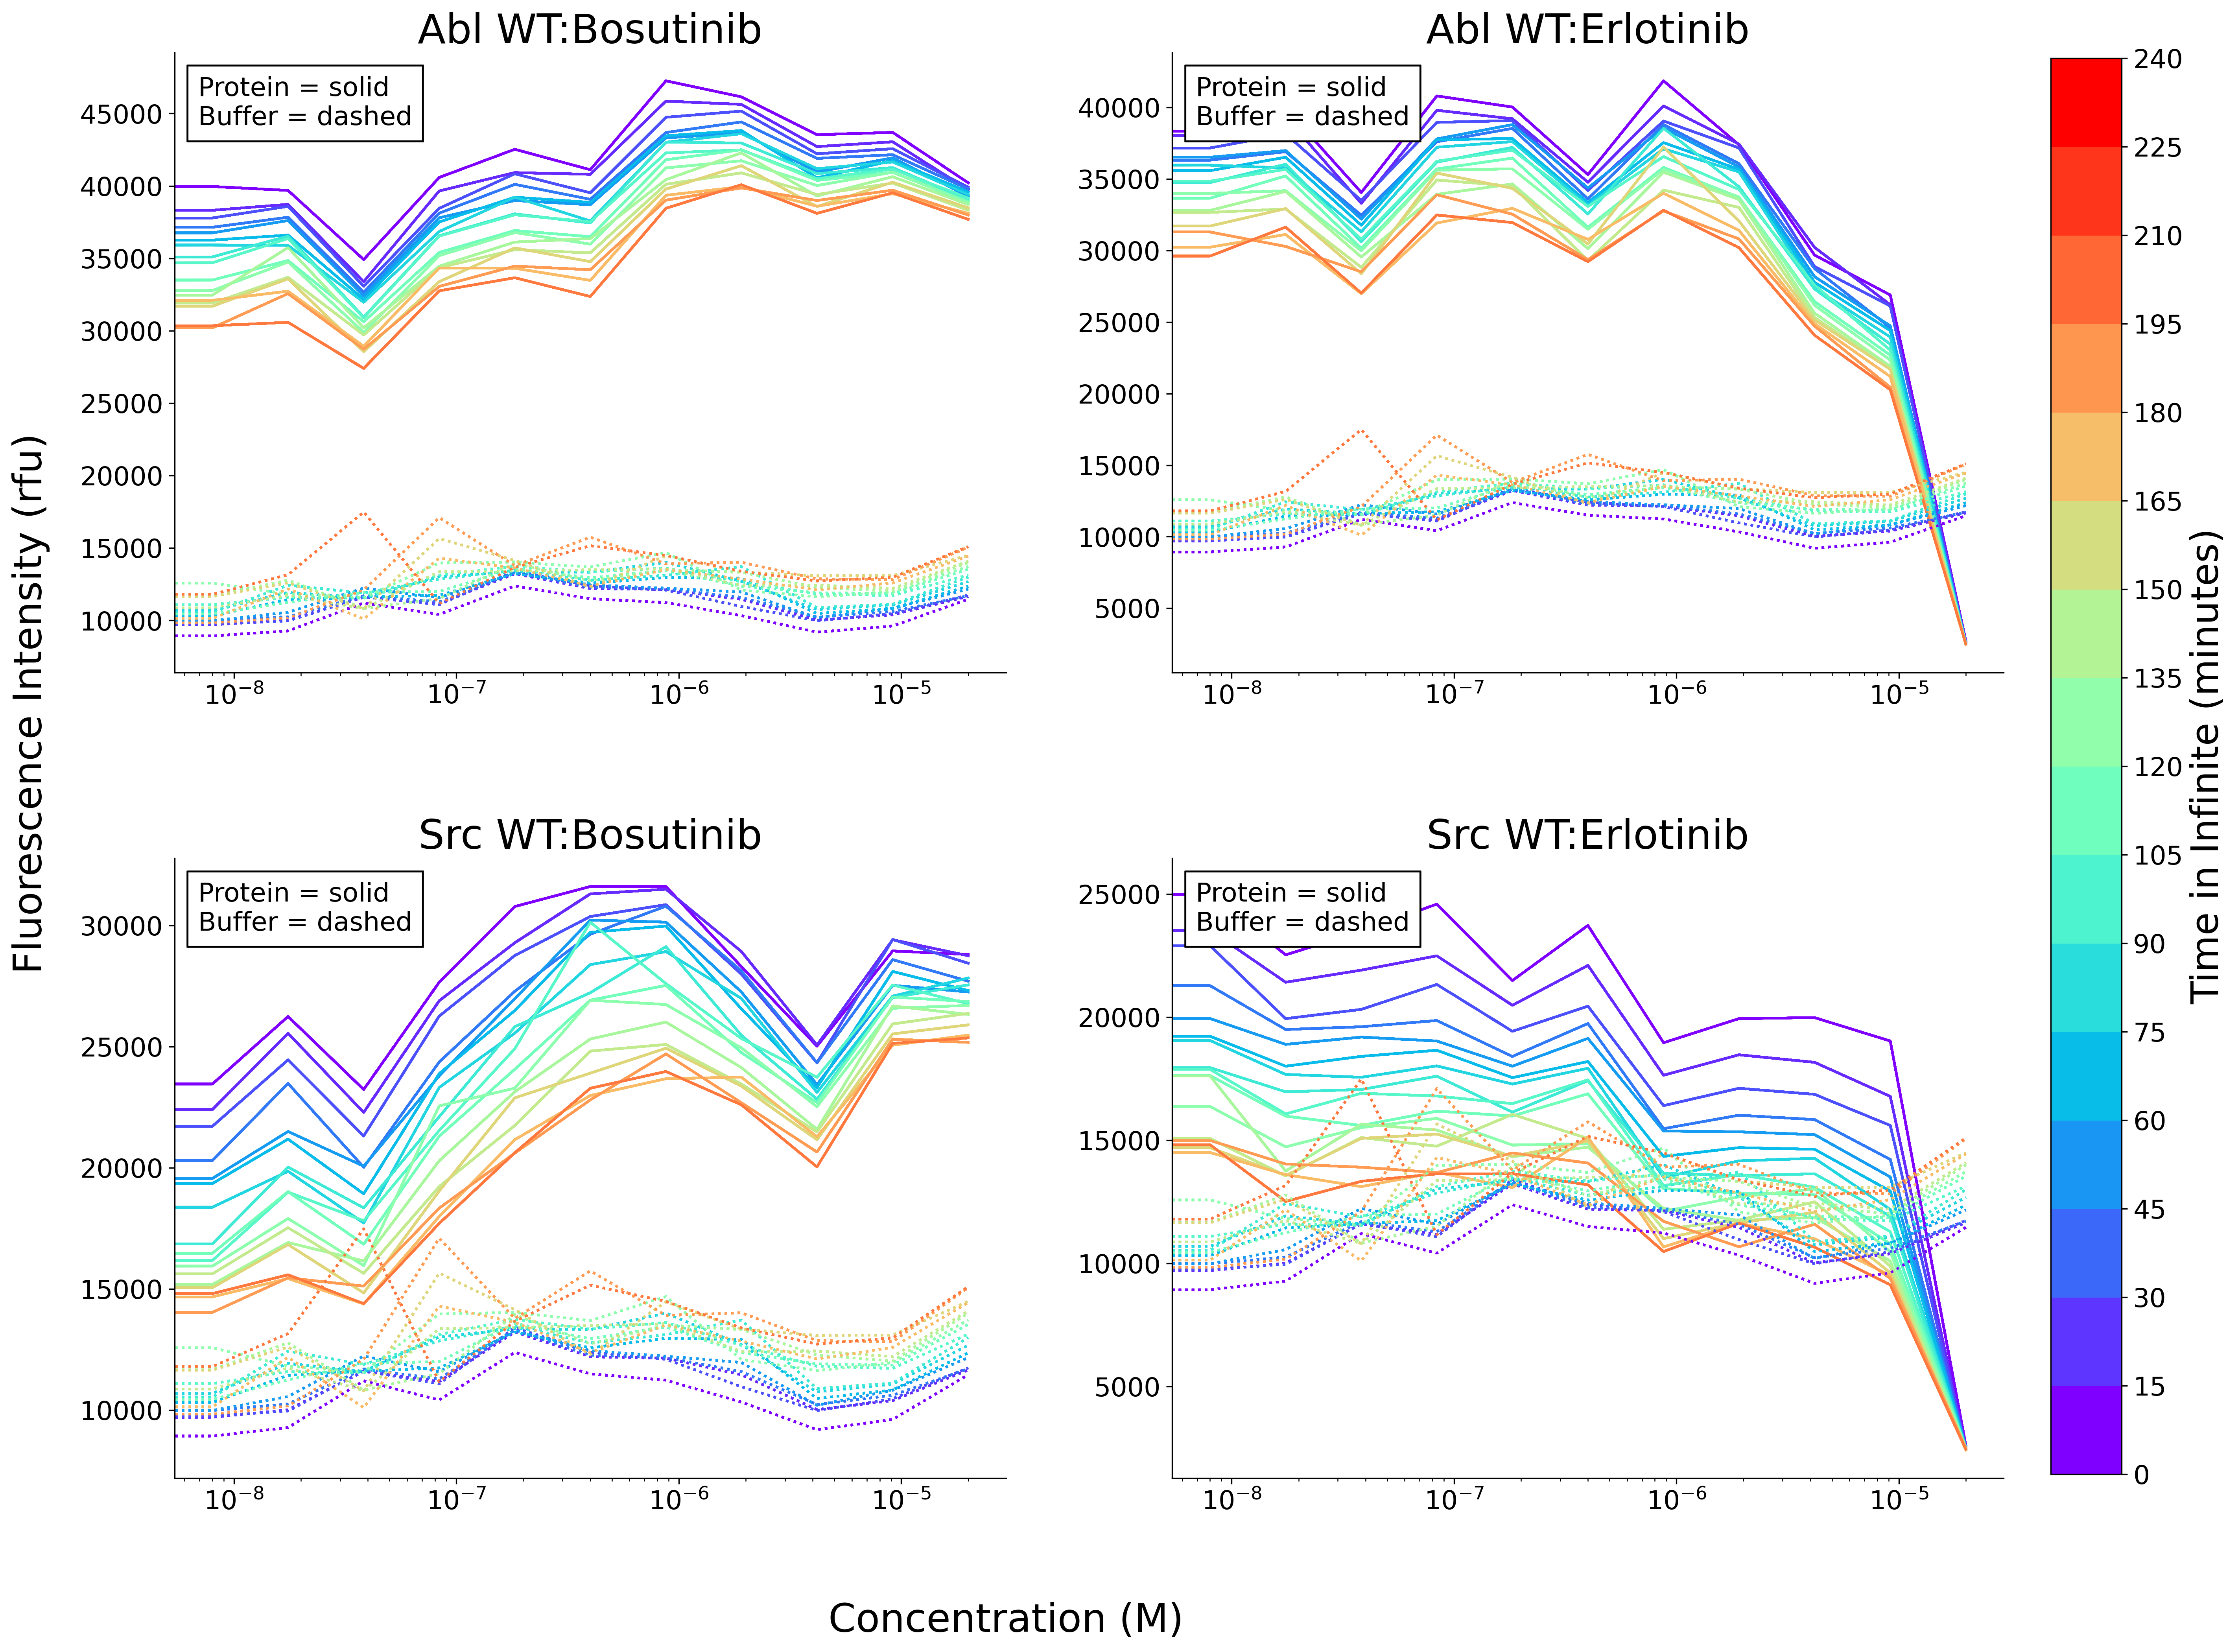

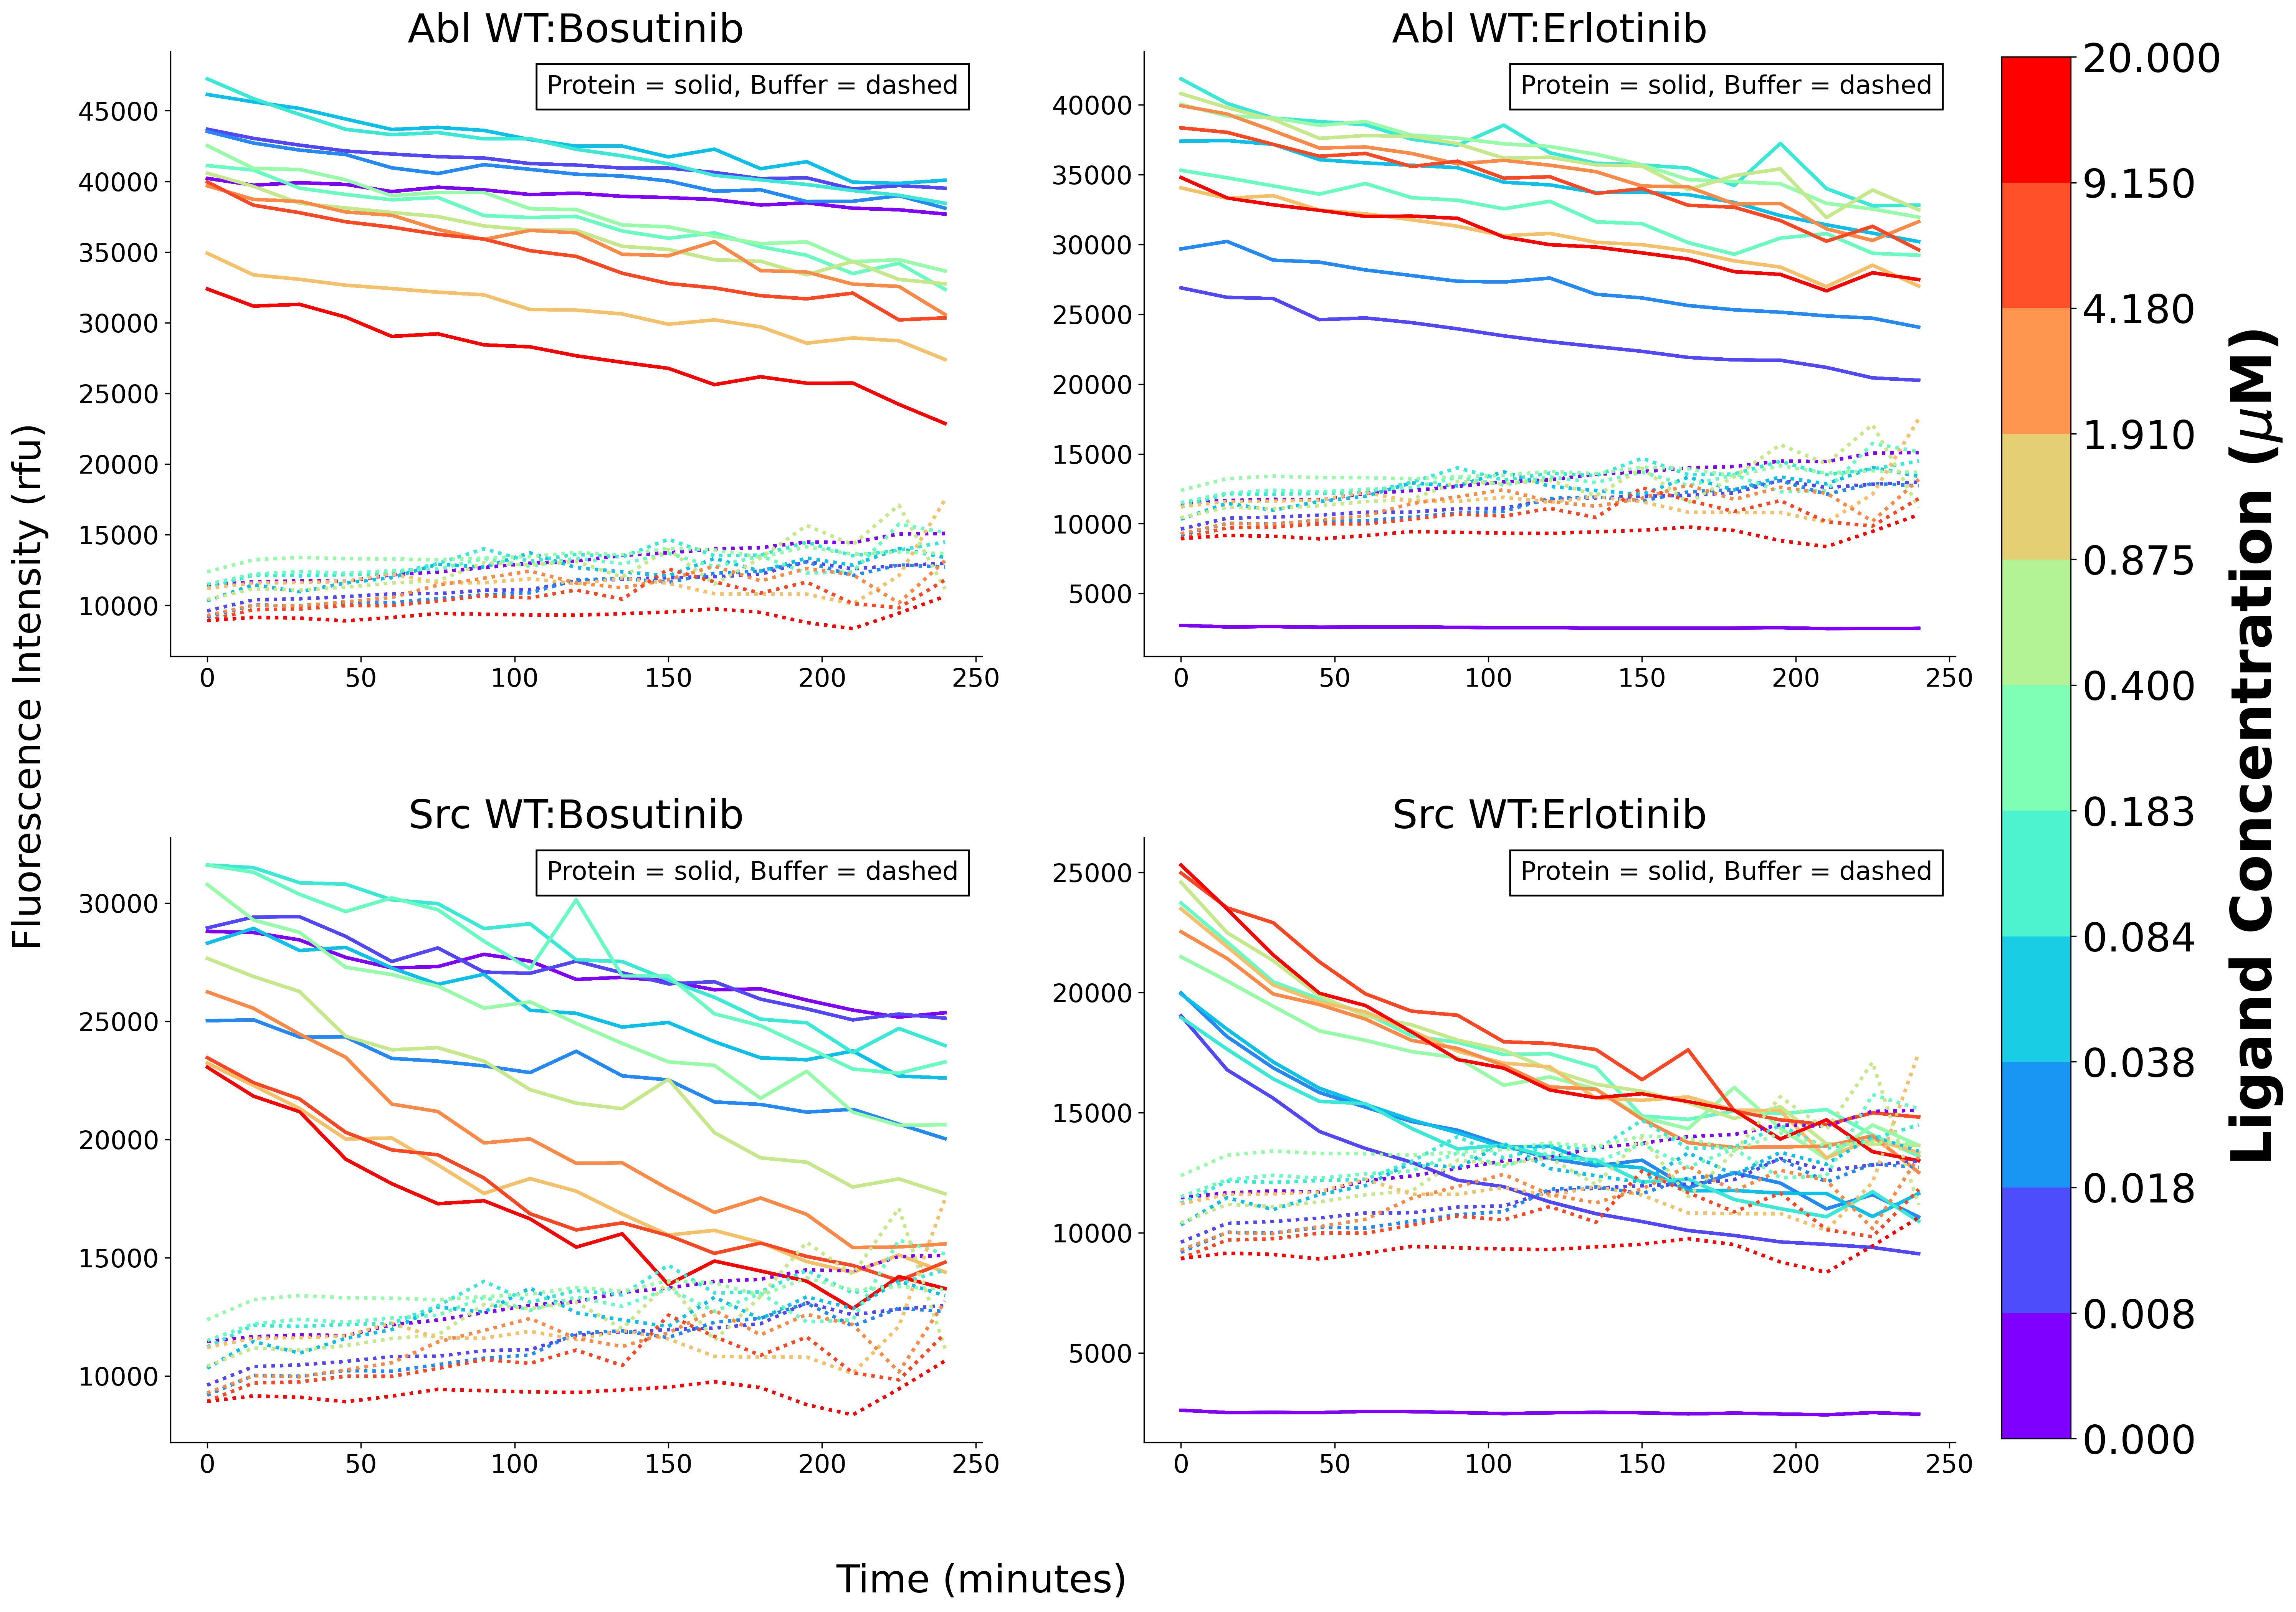

In [9]:
analyze_experiment('Greiner 96 Flat Bottom Transparent Polystyrene cat no 655101,655161,655192 [GRE96ft]', '2021-04-08 13-08-30_plate_1')